# Cleaning Redfin Data for Investigative Journalists

This notebook walks you through cleaning a Redfin 'Sold Homes' dataset using Python and pandas. The goal is to prepare the data for analysis related to housing trends and potential gentrification patterns.

In [22]:
# Step 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from google.colab import files
uploaded = files.upload()

Saving redfin.csv to redfin (1).csv


### Step 3: Check the structure of the data
Let's explore the columns and data types to understand what we have.

In [8]:

# Automatically read the uploaded CSV
filename = list(uploaded.keys())[0]  # Get the first uploaded filename
df = pd.read_csv(filename)

# Show structure
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nData Preview:")
df.head()


Shape: (159, 10)

Columns:
 ['bp-Homecard href', 'Badge', 'bp-Homecard__Photo--image src', 'bp-Homecard__Photo', 'bp-Homecard__Price--value', 'bp-Homecard__Price--label', 'bp-Homecard__Stats--beds', 'bp-Homecard__Stats--baths', 'bp-Homecard__LockedStat--value', 'bp-Homecard__Content']

Data Preview:


,bp-Homecard href,Badge,bp-Homecard__Photo--image src,bp-Homecard__Photo,bp-Homecard__Price--value,bp-Homecard__Price--label,bp-Homecard__Stats--beds,bp-Homecard__Stats--baths,bp-Homecard__LockedStat--value,bp-Homecard__Content
0,https://www.redfin.com/GA/Atlanta/3433-Keswick...,"SOLD APR 11, 2025",https://ssl.cdn-redfin.com/photo/82/islphoto/5...,"3433 Keswick Dr, Chamblee, GA 30341","$875,000",Last sold price,5 beds,4 baths,"2,963","{""@context"":""http://schema.org"",""name"":""3433 K..."
1,https://www.redfin.com/GA/Atlanta/2652-Brickel...,"SOLD BY REDFIN JUN 30, 2025",https://ssl.cdn-redfin.com/system_files/media/...,"2652 Brickell Sq, Atlanta, GA 30341","$750,000",Last sold price,4 beds,4 baths,"3,682","{""@context"":""http://schema.org"",""name"":""2652 B..."
2,https://www.redfin.com/GA/Atlanta/2485-Ortega-...,"SOLD APR 30, 2025",https://ssl.cdn-redfin.com/photo/82/islphoto/6...,"2485 Ortega Way N, Chamblee, GA 30341","$260,000",Last sold price,3 beds,2 baths,"1,720","{""@context"":""http://schema.org"",""name"":""2485 O..."
3,https://www.redfin.com/GA/Atlanta/3796-Greenhi...,"SOLD APR 28, 2025",https://ssl.cdn-redfin.com/photo/81/islphoto/0...,"3796 Greenhill Dr, Atlanta, GA 30341","$537,000",Last sold price,4 beds,2 baths,"1,593","{""@context"":""http://schema.org"",""name"":""3796 G..."
4,https://www.redfin.com/GA/Atlanta/3576-Sexton-...,"SOLD APR 10, 2025",https://ssl.cdn-redfin.com/photo/82/islphoto/7...,"3576 Sexton Woods Dr, Chamblee, GA 30341","$1,400,000",Last sold price,5 beds,4.5 baths,"4,014","{""@context"":""http://schema.org"",""name"":""3576 S..."


### Step 4: Rename columns for readability
We'll simplify long, tool-generated column names to more journalist-friendly ones.

In [9]:
df.columns = [
    "URL", "Sold_Label", "Image_URL", "Address", "Price", "Price_Label",
    "Beds", "Baths", "SqFt", "Metadata"
]
df = df[["Address", "Price", "Sold_Label", "Beds", "Baths", "SqFt", "URL"]]
df.head()

,Address,Price,Sold_Label,Beds,Baths,SqFt,URL
0,"3433 Keswick Dr, Chamblee, GA 30341","$875,000","SOLD APR 11, 2025",5 beds,4 baths,"2,963",https://www.redfin.com/GA/Atlanta/3433-Keswick...
1,"2652 Brickell Sq, Atlanta, GA 30341","$750,000","SOLD BY REDFIN JUN 30, 2025",4 beds,4 baths,"3,682",https://www.redfin.com/GA/Atlanta/2652-Brickel...
2,"2485 Ortega Way N, Chamblee, GA 30341","$260,000","SOLD APR 30, 2025",3 beds,2 baths,"1,720",https://www.redfin.com/GA/Atlanta/2485-Ortega-...
3,"3796 Greenhill Dr, Atlanta, GA 30341","$537,000","SOLD APR 28, 2025",4 beds,2 baths,"1,593",https://www.redfin.com/GA/Atlanta/3796-Greenhi...
4,"3576 Sexton Woods Dr, Chamblee, GA 30341","$1,400,000","SOLD APR 10, 2025",5 beds,4.5 baths,"4,014",https://www.redfin.com/GA/Atlanta/3576-Sexton-...


### Step 5: Clean numeric fields (price, beds, baths, sqft)
We'll remove any symbols like `$` or `,` and convert to numeric values for analysis.

In [10]:
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)
df['Beds'] = df['Beds'].str.extract(r'(\d+\.?\d*)').astype(float)
df['Baths'] = df['Baths'].str.extract(r'(\d+\.?\d*)').astype(float)
df['SqFt'] = df['SqFt'].replace({',': '', '—': None}, regex=True)
df['SqFt'] = pd.to_numeric(df['SqFt'], errors='coerce')

### Step 6: Extract sold date from the label
This gives us a usable `datetime` column for filtering or time-based analysis.

In [11]:
df['Sold_Date'] = df['Sold_Label'].str.extract(r'SOLD(?: BY REDFIN)? ([A-Z]{3} \d{1,2}, \d{4})')
df['Sold_Date'] = pd.to_datetime(df['Sold_Date'], errors='coerce')

/tmp/ipython-input-11-845270817.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Sold_Date'] = pd.to_datetime(df['Sold_Date'], errors='coerce')


### Step 7: Calculate price per square foot
This helps spot overvalued flips or gentrification signals.

In [12]:
df['Price/SqFt'] = df['Price'] / df['SqFt']

### Step 8: Extract ZIP code from the address
This enables location-based filtering and grouping.

In [13]:
df['ZIP'] = df['Address'].str.extract(r'(\d{5})')

### Final Cleaned Dataset Preview
You're now ready to begin your analysis.

In [14]:
df.head()

,Address,Price,Sold_Label,Beds,Baths,SqFt,URL,Sold_Date,Price/SqFt,ZIP
0,"3433 Keswick Dr, Chamblee, GA 30341",875000.0,"SOLD APR 11, 2025",5.0,4.0,2963.0,https://www.redfin.com/GA/Atlanta/3433-Keswick...,2025-04-11,295.308809,30341
1,"2652 Brickell Sq, Atlanta, GA 30341",750000.0,"SOLD BY REDFIN JUN 30, 2025",4.0,4.0,3682.0,https://www.redfin.com/GA/Atlanta/2652-Brickel...,2025-06-30,203.693645,30341
2,"2485 Ortega Way N, Chamblee, GA 30341",260000.0,"SOLD APR 30, 2025",3.0,2.0,1720.0,https://www.redfin.com/GA/Atlanta/2485-Ortega-...,2025-04-30,151.162791,30341
3,"3796 Greenhill Dr, Atlanta, GA 30341",537000.0,"SOLD APR 28, 2025",4.0,2.0,1593.0,https://www.redfin.com/GA/Atlanta/3796-Greenhi...,2025-04-28,337.099812,30341
4,"3576 Sexton Woods Dr, Chamblee, GA 30341",1400000.0,"SOLD APR 10, 2025",5.0,4.5,4014.0,https://www.redfin.com/GA/Atlanta/3576-Sexton-...,2025-04-10,348.779273,30341


# Additional Analysis: Trends and Potential Flips

In [15]:
# Step 2: Load your previously cleaned dataset
df = pd.read_csv('redfin.csv')

# Clean again in case it's a fresh file
df.columns = ["URL", "Sold_Label", "Image_URL", "Address", "Price", "Price_Label",
              "Beds", "Baths", "SqFt", "Metadata"]
df = df[["Address", "Price", "Sold_Label", "Beds", "Baths", "SqFt", "URL"]]
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)
df['Beds'] = df['Beds'].str.extract(r'(\d+\.?\d*)').astype(float)
df['Baths'] = df['Baths'].str.extract(r'(\d+\.?\d*)').astype(float)
df['SqFt'] = df['SqFt'].replace({',': '', '—': None}, regex=True)
df['SqFt'] = pd.to_numeric(df['SqFt'], errors='coerce')
df['Sold_Date'] = df['Sold_Label'].str.extract(r'SOLD(?: BY REDFIN)? ([A-Z]{3} \d{1,2}, \d{4})')
df['Sold_Date'] = pd.to_datetime(df['Sold_Date'], errors='coerce')
df['Price/SqFt'] = df['Price'] / df['SqFt']
df['ZIP'] = df['Address'].str.extract(r'(\d{5})')
df = df.dropna(subset=['Sold_Date', 'ZIP'])

/tmp/ipython-input-15-1838670014.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Sold_Date'] = pd.to_datetime(df['Sold_Date'], errors='coerce')


### Step 3: Choose a ZIP code to explore

In [16]:
# Show ZIP codes available
df['ZIP'].value_counts().head(10)

,count
ZIP,
30341,5
30310,5
30318,4
30331,4
30315,4
30309,4
30349,3
30328,3
30312,3


In [17]:
# Set your focus ZIP code
target_zip = '30310'  # Change this to any ZIP code in your dataset
focus_df = df[df['ZIP'] == target_zip]

### Step 4: Price Trends Over Time

/tmp/ipython-input-20-3780103061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus_df['Month'] = focus_df['Sold_Date'].dt.to_period('M')


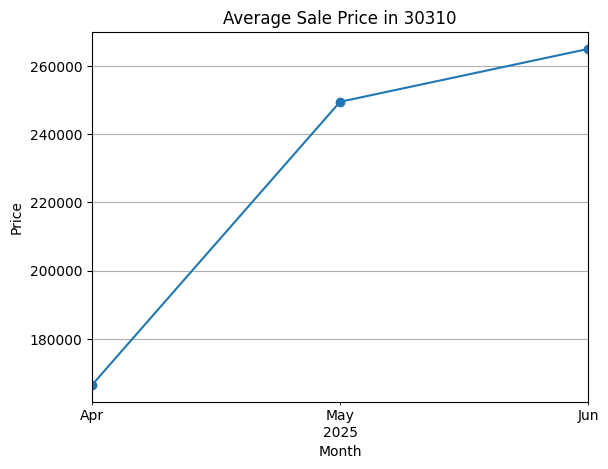

In [20]:
# Group by month to see trend
focus_df['Month'] = focus_df['Sold_Date'].dt.to_period('M')
monthly_prices = focus_df.groupby('Month')['Price'].mean()
monthly_prices.plot(title=f'Average Sale Price in {target_zip}', marker='o')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Step 5: Price Per Square Foot Distribution

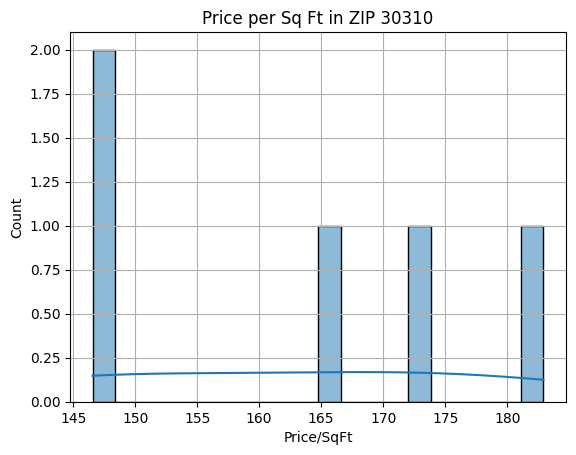

In [23]:
sns.histplot(focus_df['Price/SqFt'].dropna(), bins=20, kde=True)
plt.title(f'Price per Sq Ft in ZIP {target_zip}')
plt.xlabel('Price/SqFt')
plt.grid(True)
plt.show()

### Step 6: Identify Possible Flips
A flip might be a small house (under 1500 sqft) sold for a very high price per sqft.


In [24]:
flips = focus_df[(focus_df['SqFt'] < 1500) & (focus_df['Price/SqFt'] > 300)]
flips[['Address', 'Price', 'SqFt', 'Price/SqFt', 'Sold_Date']]

,Address,Price,SqFt,Price/SqFt,Sold_Date
